## Importa bibliotecas

In [1]:
import os
import urllib.request
import random
import numpy as np
import matplotlib.pyplot as plt
import csv
%matplotlib inline

In [2]:
random.seed = 0
np.random.seed = 0

# Classificação Binária

## Download dataset

In [3]:
data_url = 'http://www.dca.fee.unicamp.br/~lboccato/two_moons.csv'
data_dir = os.path.abspath(os.path.relpath('../data'))
data_path = os.path.join(data_dir, 'two_moons.csv')
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

urllib.request.urlretrieve(data_url, data_path)

('/home/rafael/inbox/machine-learning/2-linear-classification/data/two_moons.csv',
 <http.client.HTTPMessage at 0x7fa311770390>)

In [4]:
%%bash
head "../data/two_moons.csv"

,x_1,x_2,y
0,2.0644296514467197,0.546069086070731,1.0
1,1.762473261484448,-0.06268920285178106,1.0
2,-0.24548972654900278,1.068868024796405,0.0
3,-0.17463045222800389,0.18388168037297553,1.0
4,0.4521100769674068,-0.40651213749666293,1.0
5,1.9396117132053508,0.43090598314745787,1.0
6,0.898613370647941,0.8226576504874641,0.0
7,0.052218958530233006,1.3636857785600163,0.0
8,-0.6284662881051902,1.1413048711192604,0.0


## Importa dataset

In [5]:
dataset = np.loadtxt(data_path, skiprows=1, usecols=(1,2,3), delimiter=',')

In [6]:
dataset.shape

(1000, 3)

In [7]:
X = dataset[:,0:2]
y = dataset[:,2].astype(int)

In [8]:
Phi = np.column_stack((np.ones(X.shape[0]), X))

In [9]:
mask1 = [i for i, e in enumerate(y) if e]
mask0 = [i for i, e in enumerate(y) if not e]

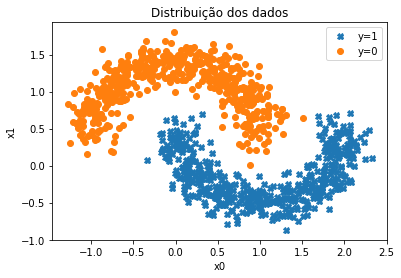

In [10]:
plt.plot(X[mask1, 0], X[mask1,1], 'X')
plt.plot(X[mask0, 0], X[mask0, 1], 'o')
plt.xlabel('x0'), plt.ylabel('x1')
plt.title("Distribuição dos dados")
plt.legend(['y=1', 'y=0'])
plt.savefig(os.path.join(image_dir, 'data.png'), bbox_inches='tight')
plt.show()

## Discriminante linear de Fischer (LDA)

In [11]:
y_hat = lambda w, X: np.dot(X, w)

In [12]:
Sw = np.zeros((2,2))
mu1 = np.mean(X[mask1], 0)
mu0 = np.mean(X[mask0], 0)

for i in mask0:
    Sw += np.dot((X[i].reshape((2,1)) - mu0.reshape((1,2))),((X[i].reshape((2,1)) - mu0.reshape((1,2)))).T)
for i in mask1:
    Sw += np.dot((X[i].reshape((2,1)) - mu1.reshape((1,2))),((X[i].reshape((2,1)) - mu1.reshape((1,2)))).T)
Sw

array([[ 2.23939149e+03, -5.36498142e-02],
       [-5.36498142e-02,  1.43394973e+03]])

In [13]:
Sb = np.dot((mu1 - mu0),(mu1 - mu0).T)
Sb

2.4003468221575144

In [14]:
J = lambda w: np.dot(np.dot(w.T, Sb), w)/np.dot(np.dot(w.T, Sw), w)

In [15]:
w = np.dot(np.linalg.inv(Sw),(mu1 - mu0))
w = w/np.linalg.norm(w)
w

array([ 0.48042956, -0.87703332])

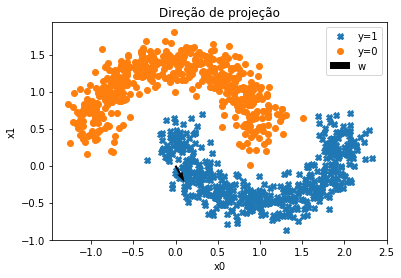

In [16]:
plt.plot(X[mask1, 0], X[mask1,1], 'X', zorder=1)
plt.plot(X[mask0, 0], X[mask0, 1], 'o', zorder=2)


origin = [0], [0] # origin point
plt.xlabel('x0'), plt.ylabel('x1')
plt.title("Direção de projeção")
plt.quiver(*origin, w[0], w[1], width=0.006, color='black', zorder=3)

# w0 = 0
# x = np.linspace(-1.5, 2.5, 1000)
# gx = w[1]/w[0]*x
# plt.plot(x, gx, 'r', zorder=4)

plt.legend(['y=1', 'y=0', 'w', 'thres = 0'])
plt.savefig(os.path.join(image_dir, 'proj.png'), bbox_inches='tight')
plt.show()

### Projeção em w

In [17]:
lda = lambda X, w: np.dot(X, w)

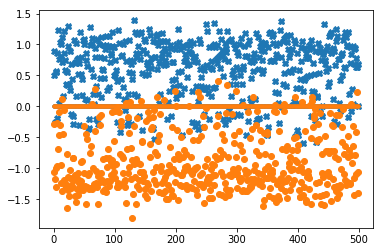

In [18]:
out = lda(X, w)
plt.stem(out[mask1], basefmt='.', linefmt='C0.', markerfmt='C0X')
plt.stem(out[mask0], basefmt='.', linefmt='C1.', markerfmt='C1o')
plt.savefig(os.path.join(image_dir, 'stem_proj.png'), bbox_inches='tight')
plt.show()

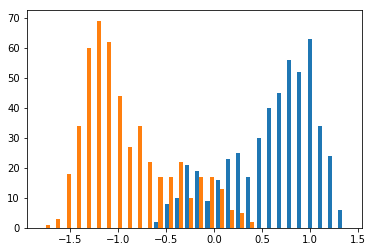

In [19]:
plt.hist([out[mask1], out[mask0]], bins=30, color=['C0', 'C1'])
plt.savefig(os.path.join(image_dir, 'hist.png'), bbox_inches='tight')
plt.show()

### Curva ROC

In [20]:
def decision(X, w, thres, model):
    out = model(X, w)
    return np.array([1 if e > thres else 0 for e in out])

In [21]:
def confusion(out, y):
    tp = fp = tn = fn = 0
    for i, e in enumerate(out):
        if e:
            if y[i]:
                tp += 1
            else:
                fp += 1
        else:
            if y[i]:
                fn += 1
            else:
                tn += 1
    return tp, fp, fn, tn

In [22]:
def roc_curve(X, y, w, thres_v, model):
    roc = []
    f1_v = []
    for t in thres_v:
        out = decision(X, w, t, model)
        tp, fp, fn, tn = confusion(out, y)
        tpr = tp/(tp+fn)
        fpr = fp/(fp+tn)
        f1 = 2*tp/(2*tp + fn + fp)
        f1_v.append([t, f1])
        roc.append([fpr, tpr])
    return np.array(roc), np.array(f1_v)

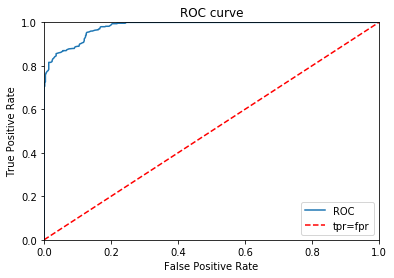

In [23]:
thres_v = [0.01*e for e in range(-200, 201)]
roc, f1 = roc_curve(X, y, w, thres_v, lda)
plt.plot(roc[:,0], roc[:,1], 'C0-')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC curve")
plt.legend(["ROC", "tpr=fpr"])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(os.path.join(image_dir, 'roc.png'), bbox_inches='tight')
plt.show()

### F1 score

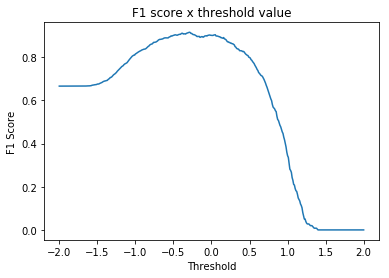

In [24]:
plt.plot(f1[:,0], f1[:,1], 'C0-')
plt.title("F1 score x threshold value")
plt.ylabel('F1 Score')
plt.xlabel('Threshold')
plt.savefig(os.path.join(image_dir, 'f1.png'), bbox_inches='tight')
plt.show()

## Regressão Logística

In [25]:
g = lambda z: 1/(1 + np.exp(-z))

In [26]:
lr = lambda Phi, w: g(np.dot(Phi, w))

In [27]:
mmq = lambda Phi, y: np.dot(np.dot(np.linalg.inv(np.dot(Phi.T, Phi)), Phi.T), y)

In [28]:
w = mmq(Phi, y)

In [198]:
def J(y_hat, y):
    J = 0
    for e, f in zip(y, y_hat):
        J += e*np.log10(f) + (1-e)*np.log10(1-f)
    return -J/y.shape[0]

In [199]:
def gradient_descent_step(y_hat, y, w, alpha):
    y = y.reshape((y.shape[0],1))
    grad = -np.dot((y - y_hat).T, Phi)/y_hat.shape[0]
    grad = np.sum(grad, 0)/y_hat.shape[0]
    return w - alpha*grad

In [225]:
def gradient_descent(Phi, y, w, alpha, epochs, early_stop_param):
    epoch = count = 0
    min_error = 999
    while epoch < epochs and count < early_stop_param:
        y_hat = lr(Phi, w)
        error = J(y_hat, y)
        w = gradient_descent_step(y_hat, y, w, alpha)
        if error < min_error:
            min_error = error
            count = 0
        else:
            count += 1
        print('.', end='')
        epoch += 1
    
    return w

In [226]:
w = 0.001*np.random.random([3])

In [227]:
w = gradient_descent(Phi, y, w, 0.001, 1000, 10)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [228]:
w

array([ 0.00057171,  0.25234984, -0.29390898])

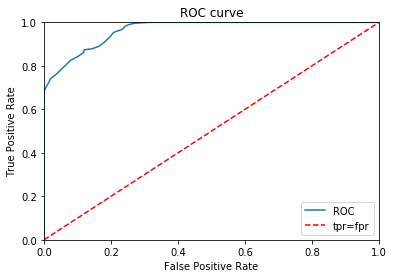

In [229]:
thres_v = [0.001*e for e in range(0,1001, 5)]
roc, f1 = roc_curve(Phi, y, w, thres_v, lr)
plt.plot(roc[:,0], roc[:,1], 'C0-')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC curve")
plt.legend(["ROC", "tpr=fpr"])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(os.path.join(image_dir, 'roc_lr.png'), bbox_inches='tight')
plt.show()

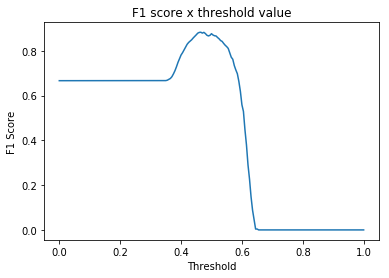

In [230]:
plt.plot(f1[:,0], f1[:,1], 'C0-')
plt.title("F1 score x threshold value")
plt.ylabel('F1 Score')
plt.xlabel('Threshold')
plt.savefig(os.path.join(image_dir, 'f1_lr.png'), bbox_inches='tight')
plt.show()

# Classificação multi-classe

## Download dataset

In [231]:
data_url = 'http://www.dca.fee.unicamp.br/~lboccato/dataset_vehicle.csv'
data_path = os.path.join(data_dir, 'dataset_vehicle.csv')

urllib.request.urlretrieve(data_url, data_path)

('/home/rafael/inbox/machine-learning/2-linear-classification/data/dataset_vehicle.csv',
 <http.client.HTTPMessage at 0x7fa30e7ce8d0>)

In [232]:
%%bash
head "../data/dataset_vehicle.csv"

"COMPACTNESS","CIRCULARITY","DISTANCE_CIRCULARITY","RADIUS_RATIO","PR.AXIS_ASPECT_RATIO","MAX.LENGTH_ASPECT_RATIO","SCATTER_RATIO","ELONGATEDNESS","PR.AXIS_RECTANGULARITY","MAX.LENGTH_RECTANGULARITY","SCALED_VARIANCE_MAJOR","SCALED_VARIANCE_MINOR","SCALED_RADIUS_OF_GYRATION","SKEWNESS_ABOUT_MAJOR","SKEWNESS_ABOUT_MINOR","KURTOSIS_ABOUT_MAJOR","KURTOSIS_ABOUT_MINOR","HOLLOWS_RATIO","Class"
95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus
107,57,106,172,50,6,255,26,28,169,280,957,264,85,5,9,181,183,bus
97,43,73,173,65,6,153,42,19,143,176,361,172,66,13,1,200,204,bus
90,43,66,157,65,9,137,48,18,146,162,281,164,67,3,3,193,202,van
86,34,62,140,61,7,122,54,17,127,141,223,112,64,2,14,200,208,van


## Importa dataset

In [233]:
X = np.loadtxt(data_path, skiprows=1, usecols=range(18), delimiter=',')
X.shape

(846, 18)

In [234]:
y = []
with open(data_path) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        y.append(row['Class'])   
len(y)

846

In [235]:
classes = list(set(y))
classes

['opel', 'saab', 'bus', 'van']

In [236]:
Y = np.zeros((len(y), len(classes)))
for i, e in enumerate(y):
    if e == classes[0]:
        Y[i,0] = 1
    elif e == classes[1]:
        Y[i,1] = 1
    elif e == classes[2]:
        Y[i,2] = 1
    else:
        Y[i,3] = 1
Y.shape

(846, 4)

In [237]:
holdout_n = int(0.3*len(y))

In [238]:
X_test = X[:holdout_n, :]
X_train = X[holdout_n:,:]
Y_test = Y[:holdout_n, :]
Y_train = Y[holdout_n:,:]
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((593, 18), (253, 18), (593, 4), (253, 4))

## Regressão Logística

In [ ]:
W = np.

## K-nearest Neighbours